# Variables and Import

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import collections
from collections import Counter
import math
from itertools import permutations, combinations
import xarray as xr
from starfish.core.image._registration.transforms_list import TransformsList
import json
from starfish.types import Axes, Levels
from starfish.image import ApplyTransform, LearnTransform, Filter
from starfish import ImageStack
from starfish.util.plot import diagnose_registration

In [3]:
total_reps = 5
total_hpis = 9
comparison = "optimized_pipeline"
decoding_strategie = "_sbd"
mask_spots = True
hpis_of_interest = (0, 8)

barcodes_3nt = ["AGC","CGC","GGC","TAC","TCC","TTC","TGA","TGT"]
barcode_dict = {"PB2": "AGC", "PB1": "CGC", "PA": "GGC", "HA": "TAC", "NP": "TCC", "NA": "TTC", "M" :"TGA", "NS": "TGT"}
gene_names_3nt = ["PB2", "PB1", "PA", "HA", "NP", "NA", "M", "NS"]
filenames = sorted(os.listdir("manual_annotation_decoded"))

data_folder = "/tank/s391697/in-situ-seq-influenza/data/"
analysis_folder = "/tank/s391697/in-situ-seq-influenza/analysis/"

# Pipeline Evaluation

## Decoding of manual annotated spots

In [79]:
from functions import get_rep_hpi_fov

In [80]:
manual_spots = pd.DataFrame(columns=["rep", "hpi", "fov","x", "y", "text", "segments"])

for file in filter(lambda f: "csv" in f, filenames):
    rep, hpi, fov = get_rep_hpi_fov(file)
    spots = pd.read_csv(f"manual_annotation/{file}", keep_default_na=False)
    spots = spots.rename(columns={"x":"y", "y":"x"}) ## napari coordinates are [y, x]
    spots = spots[(spots["x"] <= 950) & (spots["x"] >= 800)]
    spots = spots[(spots["y"] >= 650) & (spots["y"] <= 800)]

    decoded_spots = []
    annotations = spots["text"].values

    for annotation in annotations:
        bases_list = [list(annotation.split(",")[0]), list(annotation.split(",")[1]), list(annotation.split(",")[2])]
        combinations = [list(x) for x in np.array(np.meshgrid(*bases_list)).T.reshape(-1,len(bases_list))]
        valid_spots = []

        for combination in combinations:
            if "".join(combination) in barcodes_3nt:
                valid_spots.append(list(barcode_dict.keys())[list(barcode_dict.values()).index("".join(combination))])
                    
        if len(valid_spots) > 0:
            decoded_spots.append(",".join(valid_spots))
        else:
            decoded_spots.append("invalid")
            
    spots["segments"] = decoded_spots
    spots["rep"] = rep
    spots["hpi"] = hpi
    spots["fov"] = fov

    manual_spots = pd.concat([manual_spots, spots], ignore_index=True)
    spots.to_csv(f"manual_annotation_decoded/{file}", columns=["y", "x", "text", "segments"], index=False)

/tmp/ipykernel_3212910/2194553717.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  manual_spots = pd.concat([manual_spots, spots], ignore_index=True)
/tmp/ipykernel_3212910/2194553717.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  manual_spots = pd.concat([manual_spots, spots], ignore_index=True)


In [81]:
manual_spots[["rep", "hpi", "fov"]] = manual_spots[["rep", "hpi", "fov"]].apply(pd.to_numeric)
manual_spots = manual_spots.query("hpi>=@hpis_of_interest[0] & hpi<=@hpis_of_interest[1]")
manual_spots

,rep,hpi,fov,x,y,text,segments
0,0,0,5,841.017375,736.125488,"T,T,C",NA
1,0,0,5,816.641038,718.108196,"0,G,C",invalid
2,0,0,5,842.342176,758.912063,"0,A,C",invalid
3,0,0,5,846.051618,774.279754,"0,A,C",invalid
4,0,0,5,809.487114,787.262802,"0,G,C",invalid
...,...,...,...,...,...,...,...
1025,2,6,1,889.988766,655.419742,"A,G,C",PB2
1026,2,6,1,891.342161,663.540113,"0,G,C",invalid
1027,2,6,1,804.183512,660.562644,"A,G,C",PB2
1028,2,6,1,822.860366,746.367898,"T,T,C",NA


## Load pipeline results

In [82]:
from functions import get_bases_from_segments

In [83]:
pipeline_spots = pd.DataFrame(columns=["rep", "hpi", "fov", "x", "y", "segments", "nucleus"])

if decoding_strategie == "_pbd" or decoding_strategie == "_sbd":
    for file in filter(lambda f: "csv" in f, filenames):
        rep, hpi, fov = get_rep_hpi_fov(file)

        pipeline_results = pd.read_csv(f"pipeline_output/{comparison}/3nt/PR8/rep{rep}/{hpi}hpi/fov_{fov}_spots{decoding_strategie}.csv", usecols=["x", "y", "target"], keep_default_na=False)
        pipeline_results = pipeline_results.rename({"target": "segments"}, axis="columns")
        pipeline_results = pipeline_results[(pipeline_results["x"] <= 950) & (pipeline_results["x"] >= 800)]
        pipeline_results = pipeline_results[(pipeline_results["y"] >= 650) & (pipeline_results["y"] <= 800)]
        
        pipeline_results["rep"] = rep
        pipeline_results["hpi"] = hpi
        pipeline_results["fov"] = fov
        pipeline_spots = pd.concat([pipeline_spots, pipeline_results], ignore_index=True)

    pipeline_spots["bases"] = [get_bases_from_segments(pipeline_spots.iloc[i]["segments"]) for i in range(len(pipeline_spots))]
    pipeline_spots[["rep", "hpi", "fov"]] = pipeline_spots[["rep", "hpi", "fov"]].apply(pd.to_numeric)
    pipeline_spots = pipeline_spots[(pipeline_spots["hpi"] >= hpis_of_interest[0]) & (pipeline_spots["hpi"] <= hpis_of_interest[1])]
    print(pipeline_spots)

      rep  hpi  fov    x    y segments nucleus    bases
0       0    0    5  839  735       NA     NaN    T,T,C
1       0    0    5  859  759  missing     NaN  invalid
2       0    0    5  809  788  missing     NaN  invalid
3       0    0    5  873  760  missing     NaN  invalid
4       0    0    5  916  684  missing     NaN  invalid
...   ...  ...  ...  ...  ...      ...     ...      ...
2168    2    6    1  807  683  missing     NaN  invalid
2169    2    6    1  828  666      PB2     NaN    A,G,C
2170    2    6    1  950  692  missing     NaN  invalid
2171    2    6    1  832  679       NA     NaN    T,T,C
2172    2    6    1  806  706  missing     NaN  invalid

[2173 rows x 8 columns]


## Apply density masks

In [84]:
mask_pipe = []
mask_man = []

if mask_spots == True:
    for i, spot_p in pipeline_spots.iterrows():
        mask_p = np.load(f"/home/witte/master/pipeline_output/final_pipe/3nt/PR8/rep{spot_p.rep}/{spot_p.hpi}hpi/fov_{spot_p.fov}_density_mask_filtered.npy")
        mask_pipe.append(mask_p[spot_p.y, spot_p.x])
    
    for i, spot_m in manual_spots.iterrows():
        mask_m = np.load(f"/home/witte/master/pipeline_output/final_pipe/3nt/PR8/rep{spot_m.rep}/{spot_m.hpi}hpi/fov_{spot_m.fov}_density_mask_filtered.npy")
        y = int(round(spot_m.y)) 
        x = int(round(spot_m.x))
        mask_man.append(mask_m[y, x])
    print(f"{len(pipeline_spots)} Spots der Pipeline-Annotation im Annotationsbereich")
    pipeline_spots["mask"] = mask_pipe
    pipeline_spots = pipeline_spots[pipeline_spots["mask"] == False].copy()
    print(f"Davon liegen {len(pipeline_spots)} Spots in nicht-crowded Regionen")

    manual_spots["mask"] = mask_man
    manual_spots = manual_spots.query("mask==False")

2173 Spots der Pipeline-Annotation im Annotationsbereich
Davon liegen 1530 Spots in nicht-crowded Regionen


## Spot matching

In [85]:
from functions import get_spots, get_key_by_value, match_spots
from scipy.spatial.distance import euclidean

In [86]:
matched_spots_df = pd.DataFrame()

for file in filter(lambda f: "csv" in f, filenames):
    rep, hpi, fov = get_rep_hpi_fov(file)
    spots_manual, spots_pipeline = get_spots(manual_spots, pipeline_spots, rep, hpi, fov)
    spots_manual = spots_manual.reset_index(drop=True)
    spots_pipeline = spots_pipeline.reset_index(drop=True)

    manual_coords = list(zip(spots_manual.x, spots_manual.y))
    pipeline_coords = list(zip(spots_pipeline.x, spots_pipeline.y))
    matches = match_spots(manual_coords, pipeline_coords, 5)

    manual_matched = set()
    pipeline_matched = set()

    for match in matches:
        manual_idx, pipeline_idx = match
        manual_x, manual_y = manual_coords[manual_idx]
        pipeline_x, pipeline_y = pipeline_coords[pipeline_idx]
        manual_matched.add(manual_idx)
        pipeline_matched.add(pipeline_idx)

        matched_spots_df = pd.concat([
            matched_spots_df,
            pd.DataFrame({
                'file': [file],
                "rep": [rep],
                "hpi": [hpi],
                "fov": [fov],
                'x_man': [manual_x],
                'y_man': [manual_y],
                'x_pipe': [pipeline_x],
                'y_pipe': [pipeline_y],
                'distance': [euclidean((manual_x, manual_y), (pipeline_x, pipeline_y))],
                "bases_man": [spots_manual.text[manual_idx]],
                "segments_man": [spots_manual.segments[manual_idx]],
                "bases_pipe": [spots_pipeline.bases[pipeline_idx]],
                "segments_pipe": [spots_pipeline.segments[pipeline_idx]],
                "nucleus": [spots_pipeline.nucleus[pipeline_idx]]
            })
        ], ignore_index=True)

    # add unmatched manual spots
    for i in range(len(spots_manual)):
        if i not in manual_matched:
            matched_spots_df = pd.concat([
                matched_spots_df,
                pd.DataFrame({
                    'file': [file],
                    "rep": [rep],
                    "hpi": [hpi],
                    "fov": [fov],
                    'x_man': [spots_manual.x[i]],
                    'y_man': [spots_manual.y[i]],
                    'x_pipe': [None],
                    'y_pipe': [None],
                    'distance': [None],
                    "bases_man": [spots_manual.text[i]],
                    "segments_man": [spots_manual.segments[i]],
                    "bases_pipe": [None],
                    "segments_pipe": [None],
                    "nucleus": ["unknown"]
                })
            ], ignore_index=True)

    # add unmatched pipeline spots
    for i in range(len(spots_pipeline)):
        if i not in pipeline_matched:
            matched_spots_df = pd.concat([
                matched_spots_df,
                pd.DataFrame({
                    'file': [file],
                    "rep": [rep],
                    "hpi": [hpi],
                    "fov": [fov],
                    'x_man': [None],
                    'y_man': [None],
                    'x_pipe': [spots_pipeline.x[i]],
                    'y_pipe': [spots_pipeline.y[i]],
                    'distance': [None],
                    "bases_man": [None],
                    "segments_man": [None],
                    "bases_pipe": [spots_pipeline.bases[i]],
                    "segments_pipe": [spots_pipeline.segments[i]],
                    "nucleus": [spots_pipeline.nucleus[i]]
                })
            ], ignore_index=True)


matched_spots_df.to_csv(f"pipeline_evaluation_results/matched_spots_{comparison}{decoding_strategie}.csv")
matched_spots_df.head()

/tmp/ipykernel_3212910/653683023.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  matched_spots_df = pd.concat([
/tmp/ipykernel_3212910/653683023.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  matched_spots_df = pd.concat([


,file,rep,hpi,fov,x_man,y_man,x_pipe,y_pipe,distance,bases_man,segments_man,bases_pipe,segments_pipe,nucleus
0,rep0_hpi0_fov5.csv,0,0,5,841.017375,736.125488,839,735,2.310092,"T,T,C",NA,"T,T,C",NA,NaN
1,rep0_hpi0_fov5.csv,0,0,5,816.641038,718.108196,814,718,2.643254,"0,G,C",invalid,invalid,missing,NaN
2,rep0_hpi0_fov5.csv,0,0,5,842.342176,758.912063,842,758,0.974137,"0,A,C",invalid,invalid,missing,NaN
3,rep0_hpi0_fov5.csv,0,0,5,846.051618,774.279754,847,773,1.592858,"0,A,C",invalid,invalid,missing,NaN
4,rep0_hpi0_fov5.csv,0,0,5,809.487114,787.262802,809,788,0.883595,"0,G,C",invalid,invalid,missing,NaN


## Spot matching statistics

In [87]:
analytics_df = pd.DataFrame(columns=["file", "rep", "hpi", "fov", "matched_spots", "unmatched_spots_pipe", "unmatched_spots_man"])
spot_matching_df = pd.read_csv(f"pipeline_evaluation_results/matched_spots_{comparison}{decoding_strategie}.csv")

for file in filter(lambda f: "csv" in f, filenames):
    rep, hpi, fov = get_rep_hpi_fov(file)
    if hpis_of_interest[0] <= int(hpi) <= hpis_of_interest[1]:
        spot_matching_df_file = spot_matching_df[spot_matching_df["file"] == file]
        total_spots = (len(spot_matching_df_file) - (spot_matching_df_file["distance"].isna().sum())) + (spot_matching_df_file["x_man"].isna().sum()) + (len(spot_matching_df_file[spot_matching_df_file["nucleus"] == "unknown"]))
        df = pd.DataFrame({
            "file": [file],
            "rep": [rep],
            "hpi": [hpi],
            "fov": [fov],
            "total_spots" : [total_spots],
            "matched_spots": [len(spot_matching_df_file) - (spot_matching_df_file["distance"].isna().sum())],
            "unmatched_spots_pipe": [spot_matching_df_file["x_man"].isna().sum()],
            "unmatched_spots_man": [len(spot_matching_df_file[spot_matching_df_file["nucleus"] == "unknown"])],
            "matched_spots_rel": [(len(spot_matching_df_file) - (spot_matching_df_file["distance"].isna().sum()))/total_spots if total_spots > 0 else None],
            "unmatched_spots_pipe_rel": [(spot_matching_df_file["x_man"].isna().sum())/total_spots if total_spots > 0 else None],
            "unmatched_spots_man_rel": [(len(spot_matching_df_file[spot_matching_df_file["nucleus"] == "unknown"]))/total_spots if total_spots > 0 else None]
        })
        analytics_df = pd.concat([analytics_df, df])

print(f"On average, {round(np.mean(analytics_df['matched_spots_rel'].dropna().values)*100, 1)} % of all spots are matched")
print(f"On average, {round(np.mean(analytics_df['unmatched_spots_pipe_rel'].dropna().values)*100, 1)} % of all pipeline spots are unmatched")
print(f"On average, {round(np.mean(analytics_df['unmatched_spots_man_rel'].dropna().values)*100, 1)} % of all manual spots are unmatched")
analytics_df.head()

On average, 41.3 % of all spots are matched
On average, 43.1 % of all pipeline spots are unmatched
On average, 15.7 % of all manual spots are unmatched


/tmp/ipykernel_3212910/2434425345.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  analytics_df = pd.concat([analytics_df, df])


,file,rep,hpi,fov,matched_spots,unmatched_spots_pipe,unmatched_spots_man,total_spots,matched_spots_rel,unmatched_spots_pipe_rel,unmatched_spots_man_rel
0,rep0_hpi0_fov5.csv,0,0,5,11,0,0,11.0,1.000000,0.000000,0.000000
0,rep0_hpi0_fov6.csv,0,0,6,8,1,0,9.0,0.888889,0.111111,0.000000
0,rep0_hpi1_fov6.csv,0,1,6,17,1,5,23.0,0.739130,0.043478,0.217391
0,rep0_hpi1_fov7.csv,0,1,7,0,0,0,0.0,NaN,NaN,NaN
0,rep0_hpi2_fov2.csv,0,2,2,12,1,12,25.0,0.480000,0.040000,0.480000


## Spot matching plot

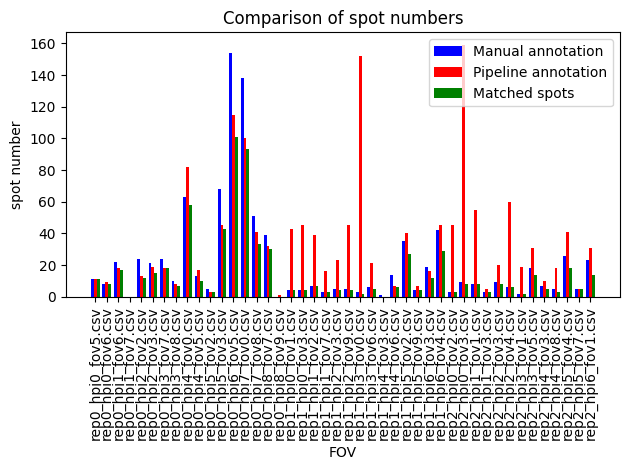

Total manual annotated spots: 927
Total pipeline annotated spots: 1530
Total matched spots: 667
Mean spots/fov, manual annotation: 21.1
Mean spots/fov, pipeline annotation: 34.8


In [88]:
y_values_man = []
y_values_pipe = []
y_values_match = []
x_values = []
x_vals_formatted = []

for file in filter(lambda f: "csv" in f, filenames):
    rep, hpi, fov = get_rep_hpi_fov(file)
    if hpis_of_interest[0] <= int(hpi) <= hpis_of_interest[1]:
        manual_spots_file, pipeline_spots_file = get_spots(manual_spots, pipeline_spots, rep, hpi, fov)
        y_values_man.append(len(manual_spots_file))
        y_values_pipe.append(len(pipeline_spots_file))
        y_values_match.append(analytics_df[analytics_df["file"] == f"rep{rep}_hpi{hpi}_fov{fov}.csv"]["matched_spots"].values[0])
        x_values.append(file)

for val in x_values:
    parts = val.split("_")
    hpi = parts[1][3:]       # "5"
    fov = parts[2][3:-4]     # "3"
    x_vals_formatted.append(f"{hpi} hpi, FOV {fov}")

x = np.arange(len(x_values))
bar_width = 0.25

fig, ax = plt.subplots()
ax.bar(x - bar_width, y_values_man, bar_width, label="Manual annotation", color="blue")
ax.bar(x, y_values_pipe, bar_width, label="Pipeline annotation", color="red")
ax.bar(x + bar_width, y_values_match, bar_width, label="Matched spots", color="green")

ax.set_xlabel("FOV")
ax.set_ylabel("spot number")
ax.set_title("Comparison of spot numbers")
ax.set_xticks(x)
ax.set_xticklabels(x_values, rotation=90)
ax.legend()
plt.tight_layout()
plt.savefig(f"pipeline_evaluation_results/spot_count_{comparison}{decoding_strategie}.png")
plt.show()

print(f"Total manual annotated spots: {len(manual_spots)}")
print(f"Total pipeline annotated spots: {sum(y_values_pipe)}")
print(f"Total matched spots: {sum(y_values_match)}")
print(f"Mean spots/fov, manual annotation: {round(sum(y_values_man)/len(y_values_man), 1)}")
print(f"Mean spots/fov, pipeline annotation: {round(sum(y_values_pipe)/len(y_values_pipe), 1)}")

In [89]:
stats_df = pd.DataFrame({
    "spots manual annotation": [len(manual_spots)],
    "spots pipeline annotation": [sum(y_values_pipe)],
    "valid spots manual annotation": [(~manual_spots["segments"].str.contains("invalid")).sum()],
    "valid spots pipe annotation": [(~pipeline_spots["bases"].str.contains("invalid")).sum()],
    "relative difference to manual annotation": [((sum(y_values_pipe) - len(manual_spots)) / len(manual_spots))*100],
    "mean spots per file manual annotation": [np.mean(y_values_man)],
    "mean spots per file pipeline annotation": [np.mean(y_values_pipe)],
    "percentage of matched spots": [np.mean(analytics_df['matched_spots_rel'].dropna().values)*100],
    "percentage of unmatched spots manual annotation": [np.mean(analytics_df['unmatched_spots_man_rel'].dropna().values)*100],
    "percentage of unmatched spots pipeline annotation": [np.mean(analytics_df['unmatched_spots_pipe_rel'].dropna().values)*100]
})
stats_df = stats_df.transpose().reset_index()
stats_df.columns = ["metric", "value"]
stats_df.value = stats_df.value.round(2)
stats_df.to_csv(f"pipeline_evaluation_results/statistics_{comparison}{decoding_strategie}.csv", index=False)

## Barcode distance from matched spots

In [90]:
from functions import get_distance_from_bases

In [91]:
matched_spots_df["barcode_distance"] = [get_distance_from_bases(matched_spots_df.iloc[i]["bases_man"], matched_spots_df.iloc[i]["bases_pipe"]) for i in range(len(matched_spots_df))]
matched_spots_df.to_csv(f"pipeline_evaluation_results/matched_spots_{comparison}{decoding_strategie}.csv", index=False)

## Plot barcode distance

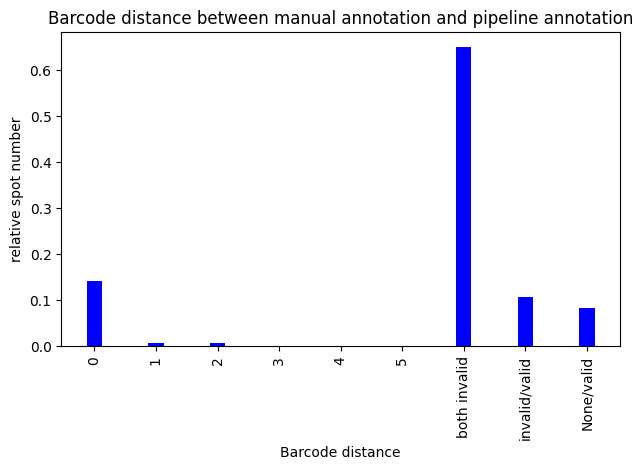

In [92]:
y_values = []
x_values = []
for x_val in matched_spots_df.barcode_distance:
    if str(x_val) not in x_values:
        x_values.append(str(x_val))
sorting = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "both invalid", "invalid/valid", "None/valid"]
x_values = sorted(
    x_values, 
    key=lambda x: sorting.index(x) if x in sorting else len(sorting) + ord(x[0])
)

for x_val in x_values:
    y_values.append(len(matched_spots_df[matched_spots_df["barcode_distance"].astype(str) == x_val]))
y_values_rel = [y_values[i]/sum(y_values) for i in range(len(y_values))]

fig, ax = plt.subplots()
ax.bar(x_values, y_values_rel, bar_width, color="blue")
ax.set_xlabel("Barcode distance")
ax.set_ylabel("relative spot number")
ax.set_title("Barcode distance between manual annotation and pipeline annotation")
ax.set_xticks(x_values)
ax.set_xticklabels(x_values, rotation=90)
plt.tight_layout()
plt.savefig(f"pipeline_evaluation_results/barcode_distance_{comparison}{decoding_strategie}.png")
plt.show()

## Barcode differences on single base level

In [93]:
from functions import get_unique_bases

In [94]:
valid_spots_df = matched_spots_df[(~matched_spots_df["bases_man"].str.contains("0", na=False)) 
                                  & (~matched_spots_df["bases_man"].str.contains("1", na=False))
                                  & (~matched_spots_df["bases_man"].isna())
                                  & (~matched_spots_df["bases_pipe"].isna())
                                  & (~matched_spots_df["bases_pipe"].str.contains("invalid", na=False))
                                  & (~matched_spots_df["bases_pipe"].str.contains("missing", na=False))]

unique_bases_man = []
unique_bases_pipe = []

for i in range(len(valid_spots_df)):
    unique_bases_man_row, unique_bases_pipe_row = get_unique_bases(valid_spots_df.iloc[i]["bases_man"], valid_spots_df.iloc[i]["bases_pipe"])
    unique_bases_man.append(unique_bases_man_row)
    unique_bases_pipe.append(unique_bases_pipe_row)

valid_spots_df["unique_bases_man"] = unique_bases_man
valid_spots_df["unique_bases_pipe"] = unique_bases_pipe
valid_spots_df

/tmp/ipykernel_3212910/3076484363.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_spots_df["unique_bases_man"] = unique_bases_man
/tmp/ipykernel_3212910/3076484363.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_spots_df["unique_bases_pipe"] = unique_bases_pipe


,file,rep,hpi,fov,x_man,y_man,x_pipe,y_pipe,distance,bases_man,segments_man,bases_pipe,segments_pipe,nucleus,barcode_distance,unique_bases_man,unique_bases_pipe
0,rep0_hpi0_fov5.csv,0,0,5,841.017375,736.125488,839,735,2.310092,"T,T,C",NA,"T,T,C",NA,NaN,0,"[[], [], []]","[[], [], []]"
11,rep0_hpi0_fov6.csv,0,0,6,853.005529,657.209013,852,656,1.572515,"G,G,C",PA,"G,G,C",PA,NaN,0,"[[], [], []]","[[], [], []]"
12,rep0_hpi0_fov6.csv,0,0,6,860.954335,710.201049,860,709,1.534038,"T,T,C",NA,"T,T,C",NA,NaN,0,"[[], [], []]","[[], [], []]"
13,rep0_hpi0_fov6.csv,0,0,6,872.082662,710.201049,871,709,1.616996,"T,C,C",NP,"T,C,C",NP,NaN,0,"[[], [], []]","[[], [], []]"
14,rep0_hpi0_fov6.csv,0,0,6,902.818043,726.893540,901,728,2.128270,"T,T,C",NA,"T,T,C",NA,NaN,0,"[[], [], []]","[[], [], []]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1757,rep2_hpi6_fov1.csv,2,6,1,869.687839,669.495052,871,670,1.405966,"T,G,A",M,"T,G,A",M,NaN,0,"[[], [], []]","[[], [], []]"
1759,rep2_hpi6_fov1.csv,2,6,1,818.529501,671.389805,819,673,1.677527,"T,G,T",NS,"T,G,T",NS,NaN,0,"[[], [], []]","[[], [], []]"
1761,rep2_hpi6_fov1.csv,2,6,1,889.988766,655.419742,891,651,4.533952,"A,G,C",PB2,"AG,G,C","PB2,PA",NaN,1,"[[], [], []]","[[G], [], []]"
1762,rep2_hpi6_fov1.csv,2,6,1,804.183512,660.562644,805,661,0.926246,"A,G,C",PB2,"AG,G,C","PB2,PA",NaN,1,"[[], [], []]","[[G], [], []]"


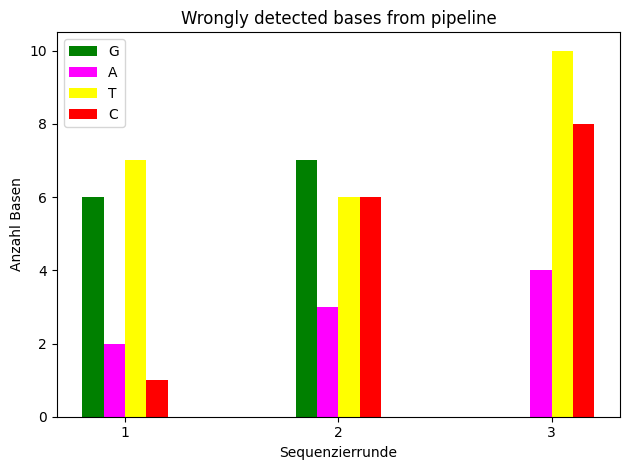

In [95]:
y_values_G = []
y_values_A = []
y_values_T = []
y_values_C = []
x_values = [i+1 for i in range(3)]

for run in range(3):
    bases_counts_dict = {"A_man": 0, "G_man": 0, "C_man": 0, "T_man": 0, "A_pipe": 0, "G_pipe": 0, "C_pipe": 0, "T_pipe": 0}

    for i in range(len(valid_spots_df)):
        row = valid_spots_df.iloc[i]
        unique_man = row.unique_bases_man[run]
        unique_pipe = row.unique_bases_pipe[run]
        for base in unique_man:
            bases_counts_dict[f"{base}_man"] += 1
        for base in unique_pipe:
            bases_counts_dict[f"{base}_pipe"] += 1
    y_values_G.append(bases_counts_dict["G_man"] + bases_counts_dict["G_pipe"])
    y_values_T.append(bases_counts_dict["T_man"] + bases_counts_dict["T_pipe"])
    y_values_A.append(bases_counts_dict["A_man"] + bases_counts_dict["A_pipe"])
    y_values_C.append(bases_counts_dict["C_man"] + bases_counts_dict["C_pipe"])


x = np.arange(len(x_values))
bar_width = 0.1

fig, ax = plt.subplots()
ax.bar(x - 1.5*bar_width, y_values_G, bar_width, label="G", color="green")
ax.bar(x - 0.5*bar_width, y_values_A, bar_width, label="A", color="magenta")
ax.bar(x + 0.5*bar_width, y_values_T, bar_width, label="T", color="yellow")
ax.bar(x + 1.5*bar_width, y_values_C, bar_width, label="C", color="red")

ax.set_xlabel("Sequenzierrunde")
ax.set_ylabel("Anzahl Basen")
ax.set_title("Wrongly detected bases from pipeline")
ax.set_xticks(x)
ax.set_xticklabels(x_values)
ax.legend()
plt.tight_layout()
plt.savefig(f"pipeline_evaluation_results//wrong_detected_bases_{comparison}{decoding_strategie}.png")
plt.show()

# Compare different pipeline versions

In [96]:
import matplotlib.image as mpimg

In [97]:
name_results1 = "final_pipe"
name_results2 = "optimized_pipeline"
decoding_strategie = "_sbd"

stats_result1 = pd.read_csv(f"pipeline_evaluation_results/statistics_{name_results1}{decoding_strategie}.csv")
stats_result2 = pd.read_csv(f"pipeline_evaluation_results/statistics_{name_results2}{decoding_strategie}.csv")
stats_both = pd.concat([stats_result1, stats_result2["value"]], axis=1)
stats_both.columns = ["metric", name_results1, name_results2]
stats_both

,metric,final_pipe,optimized_pipeline
0,spots manual annotation,927.00,927.00
1,spots pipeline annotation,1530.00,1530.00
2,valid spots manual annotation,550.00,550.00
3,valid spots pipe annotation,357.00,357.00
4,relative difference to manual annotation,65.05,65.05
5,mean spots per file manual annotation,21.07,21.07
6,mean spots per file pipeline annotation,34.77,34.77
7,percentage of matched spots,41.26,41.26
8,percentage of unmatched spots manual annotation,15.68,15.68
9,percentage of unmatched spots pipeline annotation,43.07,43.07


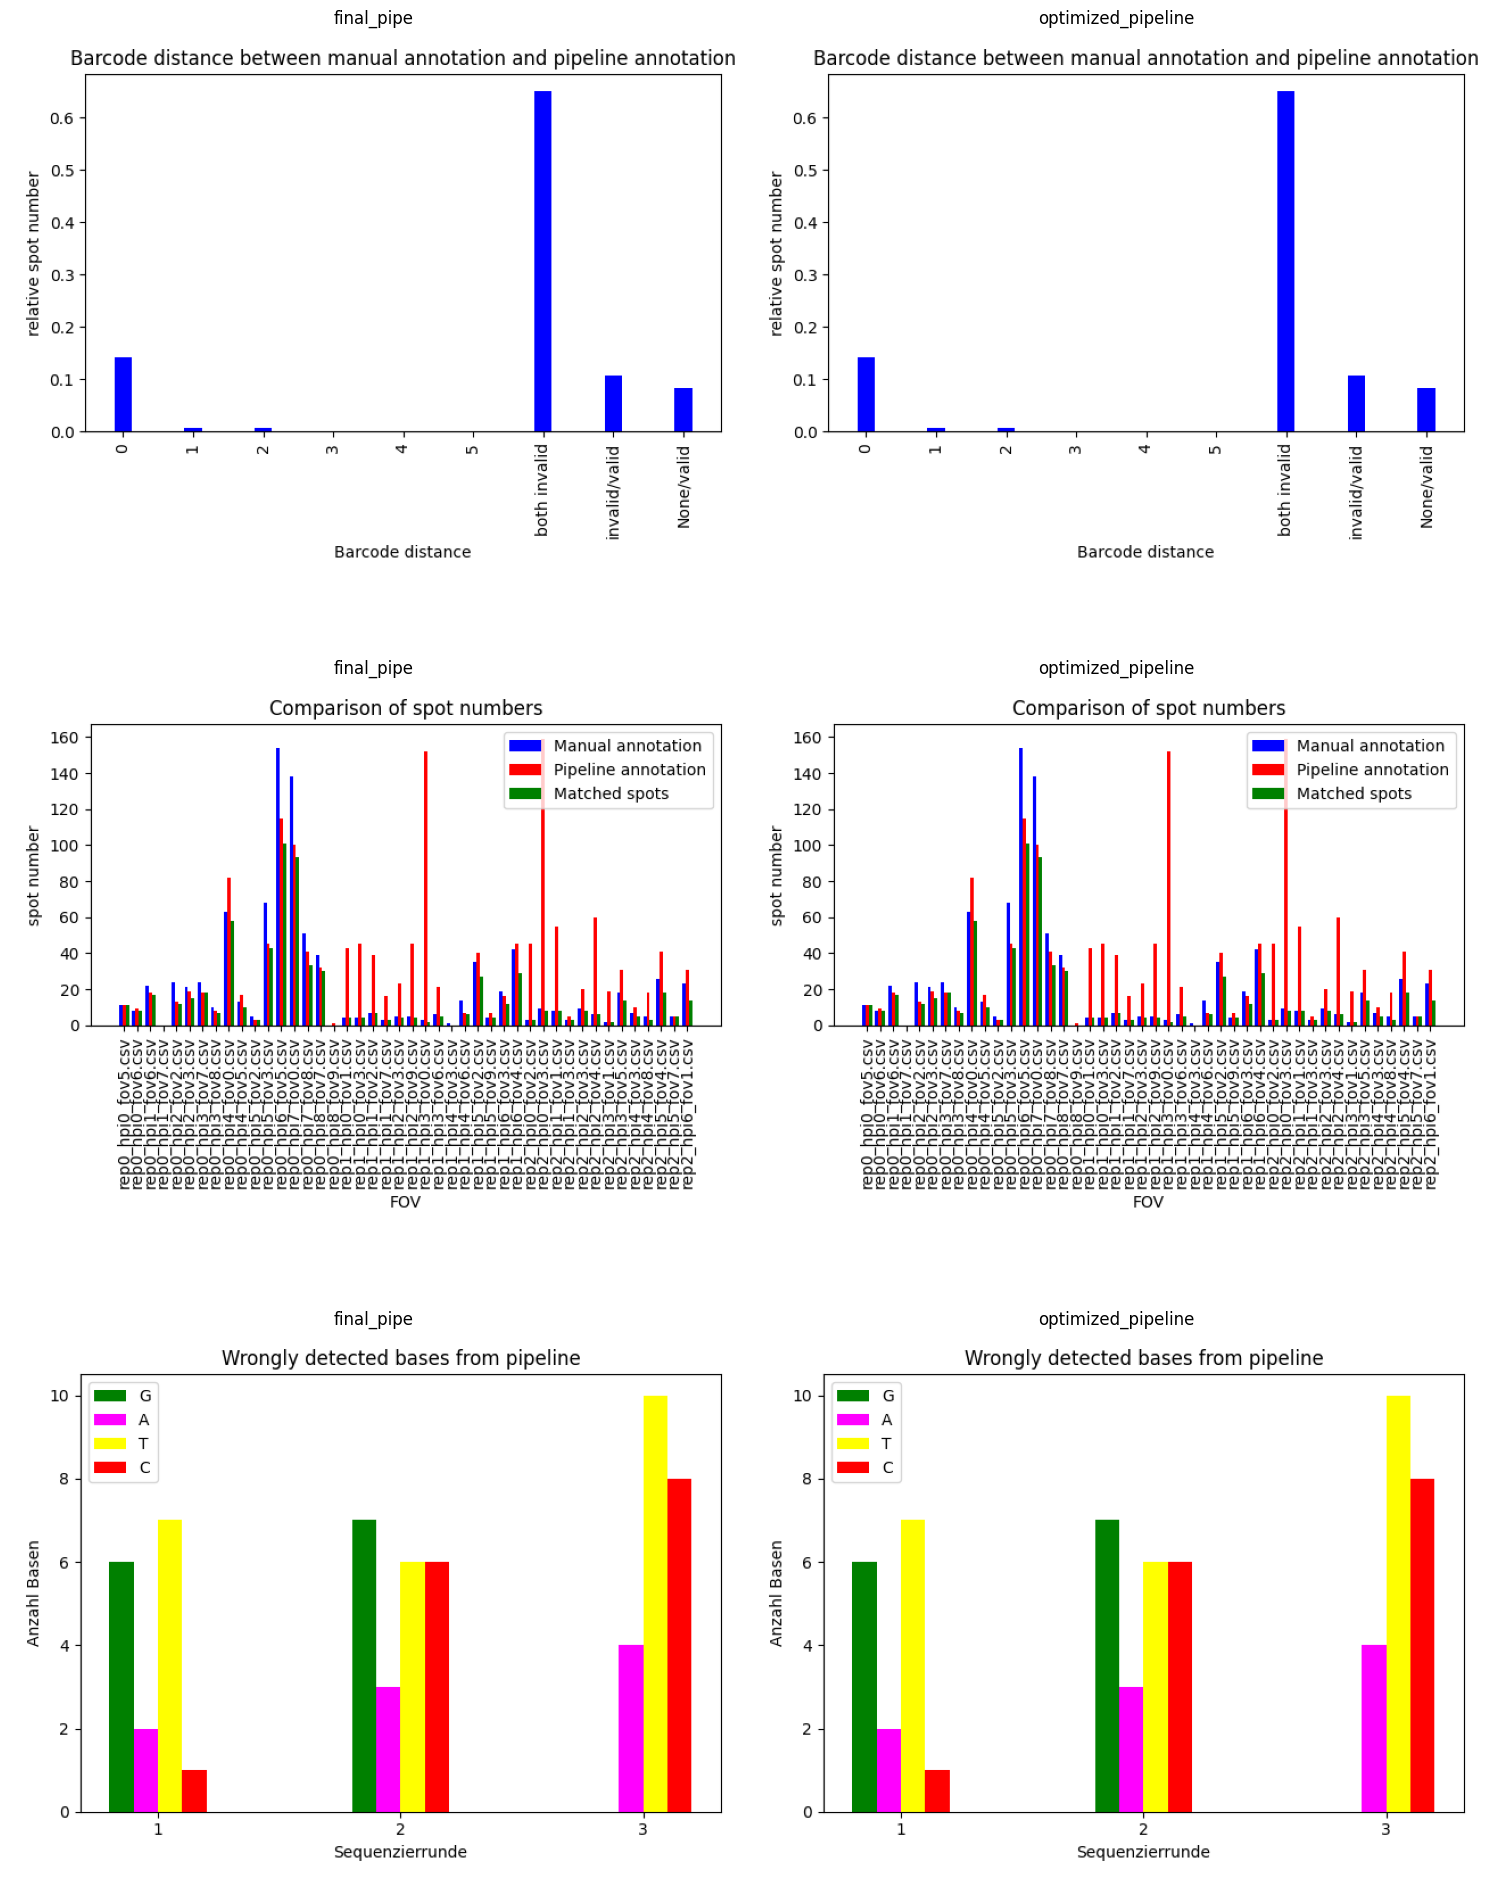

In [98]:
results1_paths = sorted([f for f in os.listdir("pipeline_evaluation_results/") if f"{name_results1}{decoding_strategie}" in f and ".png" in f])
results2_paths = sorted([f for f in os.listdir("pipeline_evaluation_results/") if f"{name_results2}{decoding_strategie}" in f and ".png" in f])

fig, axs = plt.subplots(len(results1_paths), 2, figsize=(15,20))

for i in range(len(results1_paths)):
    img1 = mpimg.imread(f"pipeline_evaluation_results/{results1_paths[i]}")
    axs[i,0].imshow(img1)
    axs[i,0].set_title(f"{name_results1}")
    axs[i,0].axis("off")

    img2 = mpimg.imread(f"pipeline_evaluation_results/{results2_paths[i]}")
    axs[i,1].imshow(img2)
    axs[i,1].set_title(f"{name_results2}")
    axs[i,1].axis("off")

plt.tight_layout()

# Spot based decoding vs. pixel based decoding

## Load mask and spots

In [10]:
import glob

In [11]:
## combine all spots in one dataframe
spots_sbd_all = pd.DataFrame()
spots_pbd_all = pd.DataFrame()

for rep in range(total_reps):
    for hpi in range(total_hpis):
        folder_path = f"pipeline_output/final_pipe/3nt/PR8/rep{rep}/{hpi}hpi"
        files = os.listdir(folder_path)
        total_fovs = len(glob.glob(os.path.join(folder_path, "fov_*_spots.nc")))

        for fov in range(total_fovs):
            if rep == 1 and hpi == 1 and fov == 0:
                continue

            prefix = f"{folder_path}/fov_{fov}"
            spots_sbd = pd.read_csv(f"{prefix}_spots_sbd.csv", keep_default_na=False)
            spots_pbd = pd.read_csv(f"{prefix}_spots_pbd.csv", keep_default_na=False)
            spots_sbd["rep"] = rep
            spots_pbd["rep"] = rep
            spots_sbd["hpi"] = hpi
            spots_pbd["hpi"] = hpi
            spots_sbd["fov"] = fov
            spots_pbd["fov"] = fov

            spots_sbd_all = pd.concat([spots_sbd_all, spots_sbd])
            spots_pbd_all = pd.concat([spots_pbd_all, spots_pbd])

## RNA counts in crowded and uncrowded regions

In [12]:
from functions import count_words
import collections

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

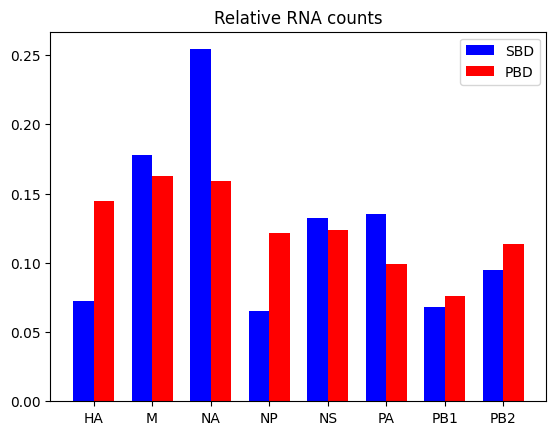

In [14]:
## filter spots
spots = pd.read_csv("data/all_spots.csv", keep_default_na=False, low_memory=False)
spots_sbd = spots[spots["iter"] == ""]
spots_pbd = spots[spots["iter"] != ""]

rnas_sbd = count_words(list(spots_sbd["target"]), list(barcode_dict.keys()))
rnas_pbd = count_words(list(spots_pbd_all["target"]), list(barcode_dict.keys()))
rnas_sbd = collections.OrderedDict(sorted(rnas_sbd.items()))
rnas_pbd = collections.OrderedDict(sorted(rnas_pbd.items()))
sbd_rel_counts = [(list(rnas_sbd.values())[i] / np.sum(list(rnas_sbd.values()))) for i in range(len(rnas_sbd))]
pbd_rel_counts = [(list(rnas_pbd.values())[i] / np.sum(list(rnas_pbd.values()))) for i in range(len(rnas_pbd))]

x = np.arange(len(rnas_pbd))
bar_width = 0.35

fig, ax = plt.subplots()
ax.bar(x - bar_width/2, sbd_rel_counts, bar_width, label="SBD", color="blue")
ax.bar(x + bar_width/2, pbd_rel_counts, bar_width, label="PBD", color="red")
ax.set_xticks(x)
ax.set_xticklabels(rnas_sbd.keys())
ax.legend()
plt.title("Relative RNA counts")
plt.tight_layout

## RNA counts uncrowded regions

In [15]:
from functions import get_rep_hpi_fov, count_words

/tmp/ipykernel_1913197/783662718.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  spots_man = pd.concat([spots_man, spots_man_file])


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

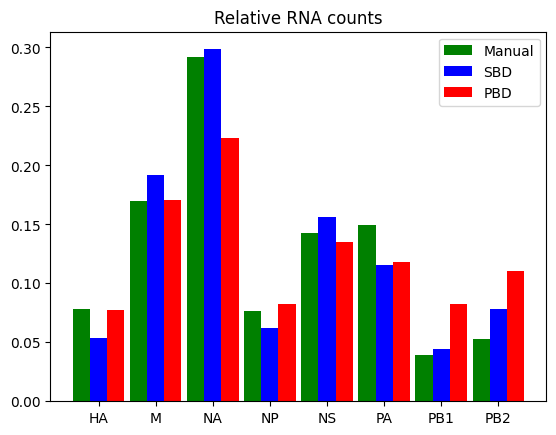

In [18]:
spots = pd.read_csv("data/all_spots.csv", keep_default_na=False, low_memory=False)
spots_sbd = pd.DataFrame()
spots_pbd = pd.DataFrame()
spots_man = pd.DataFrame()

for file in filenames:
    rep, hpi, fov = get_rep_hpi_fov(file)
    mask = np.load(f"pipeline_output/final_pipe/3nt/PR8/rep{rep}/{hpi}hpi/fov_{fov}_density_mask_filtered.npy")

    spots_man_file = pd.read_csv(f"manual_annotation_decoded/{file}", keep_default_na=False)
    spots_man_file["densed_region_filtered"] = [mask[int(spots_man_file.iloc[i]["y"]), int(spots_man_file.iloc[i]["x"])] for i in range(len(spots_man_file))]
    spots_man_file = spots_man_file.query("densed_region_filtered==False")
    spots_sbd_file = pd.read_csv(f"pipeline_output/final_pipe/3nt/PR8/rep{rep}/{hpi}hpi/fov_{fov}_spots_sbd.csv", keep_default_na=False)
    spots_sbd_file = spots_sbd_file.query("x<=950 & x>= 800 & y>=650 & y<=800 & densed_region_filtered==False")
    spots_pbd_file = pd.read_csv(f"pipeline_output/final_pipe/3nt/PR8/rep{rep}/{hpi}hpi/fov_{fov}_spots_pbd.csv", keep_default_na=False)
    spots_pbd_file = spots_pbd_file.query("x<=950 & x>= 800 & y>=650 & y<=800 & densed_region_filtered==False & radius>=1 & radius<=12")

    spots_man = pd.concat([spots_man, spots_man_file])
    spots_sbd = pd.concat([spots_sbd ,spots_sbd_file])
    spots_pbd = pd.concat([spots_pbd ,spots_pbd_file])

rnas_sbd_unsorted = count_words(list(spots_sbd["target"]), list(barcode_dict.keys()))
rnas_pbd_unsorted = count_words(list(spots_pbd["target"]), list(barcode_dict.keys()))
rnas_man_unsorted = count_words(list(spots_man["segments"]), list(barcode_dict.keys()))
rnas_sbd = collections.OrderedDict(sorted(rnas_sbd_unsorted.items()))
rnas_pbd = collections.OrderedDict(sorted(rnas_pbd_unsorted.items()))
rnas_man = collections.OrderedDict(sorted(rnas_man_unsorted.items()))
sbd_rel_counts = [(list(rnas_sbd.values())[i] / np.sum(list(rnas_sbd.values()))) for i in range(len(rnas_sbd))]
pbd_rel_counts = [(list(rnas_pbd.values())[i] / np.sum(list(rnas_pbd.values()))) for i in range(len(rnas_pbd))]
man_rel_counts = [(list(rnas_man.values())[i] / np.sum(list(rnas_man.values()))) for i in range(len(rnas_man))]

x = np.arange(len(rnas_pbd))
bar_width = 0.30

fig, ax = plt.subplots()
ax.bar(x - bar_width, man_rel_counts, bar_width, label="Manual", color="green")
ax.bar(x, sbd_rel_counts, bar_width, label="SBD", color="blue")
ax.bar(x + bar_width, pbd_rel_counts, bar_width, label="PBD", color="red")
ax.set_xticks(x)
ax.set_xticklabels(rnas_sbd.keys())
ax.legend()
plt.title("Relative RNA counts")
plt.tight_layout

# Evaluate model for masking crowded and uncrowded regions

### Load results

In [19]:
def get_rep_hpi_fov2(filename):
    file_segments = filename.split("_")
    rep = file_segments[0][-1]
    hpi = file_segments[1][-1]
    fov = file_segments[2][-1]
    return rep, hpi, fov

In [24]:
pred_df = pd.read_csv("data/image_features_with_predictions.csv")
reps = []
hpis = []
fovs = []

for i in range(len(pred_df)):
    row = pred_df.iloc[i]
    rep,hpi,fov_idx = get_rep_hpi_fov2(row.file)
    reps.append(rep)
    hpis.append(hpi)
    fovs.append(fov_idx)

pred_df["rep"] = reps
pred_df["hpi"] = hpis
pred_df["fov"] = fovs
pred_df

,file,min_intensity,max_intensity,mean_intensity,std_intensity,skewness,kurtosis,percentile_25,percentile_50,percentile_75,...,hist_bin_14,hist_bin_15,hist_bin_16,hist_bin_17,hist_bin_18,hist_bin_19,predicted_percentile,rep,hpi,fov
0,rep0_hpi0_fov5,0.0,2.583840,0.008636,0.034878,16.948481,435.068768,0.000663,0.002874,0.007417,...,0.000012,0.000015,0.000004,0.000002,0.000000,0.000004,100.000000,0,0,5
1,rep0_hpi0_fov6,0.0,2.596851,0.012842,0.051713,13.939571,281.806621,0.000960,0.003964,0.010055,...,0.000077,0.000036,0.000040,0.000025,0.000006,0.000008,100.000000,0,0,6
2,rep0_hpi1_fov6,0.0,2.751840,0.014232,0.057364,12.993707,239.119854,0.000650,0.003812,0.010828,...,0.000056,0.000045,0.000011,0.000009,0.000005,0.000002,100.000000,0,1,6
3,rep0_hpi1_fov7,0.0,2.374916,0.010147,0.039076,17.276874,456.953838,0.000000,0.001272,0.010062,...,0.000074,0.000048,0.000034,0.000021,0.000008,0.000004,100.000000,0,1,7
4,rep0_hpi2_fov2,0.0,2.638838,0.015841,0.056638,12.046353,206.508332,0.001508,0.005273,0.013130,...,0.000043,0.000028,0.000023,0.000013,0.000008,0.000008,100.000000,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454,rep4_hpi8_fov5,0.0,2.689484,0.097983,0.145450,3.006856,14.660712,0.003210,0.041895,0.131406,...,0.000170,0.000078,0.000053,0.000037,0.000010,0.000016,58.599179,4,8,5
455,rep4_hpi8_fov6,0.0,2.904507,0.108708,0.174305,2.775405,10.563722,0.000000,0.033855,0.140624,...,0.000081,0.000044,0.000019,0.000008,0.000004,0.000004,56.413570,4,8,6
456,rep4_hpi8_fov7,0.0,3.094361,0.107943,0.159518,2.635247,10.128768,0.000070,0.042945,0.148560,...,0.000014,0.000012,0.000012,0.000004,0.000004,0.000004,60.334089,4,8,7
457,rep4_hpi8_fov8,0.0,2.926015,0.099958,0.171023,2.861965,11.387719,0.000000,0.020633,0.126808,...,0.000086,0.000071,0.000021,0.000013,0.000008,0.000004,62.441547,4,8,8


## Model vs. manual prediction

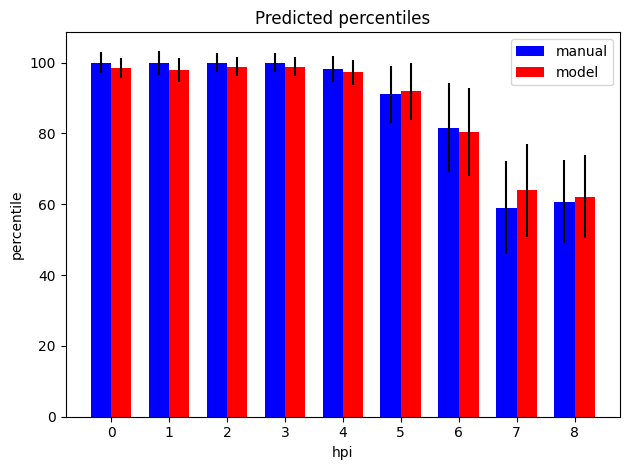

In [25]:
manual_percentiles = []
model_percentiles = []
manual_std = []
model_std = []
x = np.arange(9)
bar_width = 0.35

for hpi in range(9):
    df = pred_df[pred_df["hpi"] == f"{hpi}"]
    man_percentiles = df[~df["manual_percentile"].isna()]["predicted_percentile"].values
    modelling_percentiles = df[df["manual_percentile"].isna()]["predicted_percentile"].values
    manual_percentiles.append(np.mean(man_percentiles)) 
    model_percentiles.append(np.mean(modelling_percentiles))
    manual_std.append(np.std(man_percentiles, ddof=1))
    model_std.append(np.std(modelling_percentiles, ddof=1))

fig, ax = plt.subplots()
ax.bar(x - bar_width/2, manual_percentiles, bar_width, label="manual", color="blue", yerr=model_std)
ax.bar(x + bar_width/2, model_percentiles, bar_width, label="model", color="red", yerr=model_std)
ax.set_title("Predicted percentiles")
ax.set_xticks(x)
ax.set_xticklabels(x)
ax.set_xlabel("hpi")
ax.set_ylabel("percentile")
plt.legend()
plt.tight_layout()
plt.show()

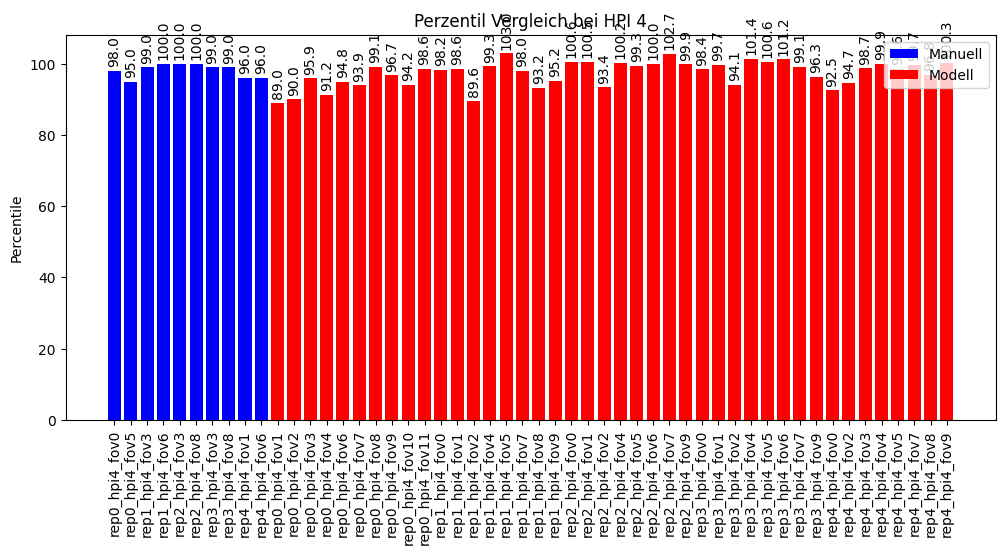

In [26]:
selected_hpi = 4

x_files = []
pred_df_hpi = pred_df[pred_df["hpi"] == f"{selected_hpi}"]
manual_percentiles_hpi = pred_df_hpi[~pred_df_hpi["manual_percentile"].isna()]["predicted_percentile"].values
x_files.append(pred_df_hpi[~pred_df_hpi["manual_percentile"].isna()]["file"].values)
model_percentiles_hpi = pred_df_hpi[pred_df_hpi["manual_percentile"].isna()]["predicted_percentile"].values
x_files.append(pred_df_hpi[pred_df_hpi["manual_percentile"].isna()]["file"].values)

def flatten(xss):
    return [x for xs in xss for x in xs]
x_files = flatten(x_files)

x_manual = np.arange(len(manual_percentiles_hpi))
x_model = np.arange(len(manual_percentiles_hpi), len(manual_percentiles_hpi) + len(model_percentiles_hpi))

plt.figure(figsize=(12, 5))
bars_manual = plt.bar(x_manual, manual_percentiles_hpi, color='blue', label='Manuell')
bars_model = plt.bar(x_model, model_percentiles_hpi, color='red', label='Modell')

def annotate_bars(bars):
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height:.1f}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),
                     textcoords="offset points",
                     ha='center', va='bottom', rotation=90)

annotate_bars(bars_manual)
annotate_bars(bars_model)
plt.ylabel('Percentile')
plt.title(f'Perzentil Vergleich bei HPI {selected_hpi}')
plt.legend()
plt.xticks(np.concatenate([x_manual, x_model]), labels=x_files, rotation=90)
plt.show()

# Analysis FOV-overlaps

## Load coordinates from metadata

In [28]:
coords = pd.DataFrame()

for rep in range(total_reps):
    for hpi in range(total_hpis):
        paths_coords = sorted(glob.glob(f"/tank/s391697/in-situ-seq-influenza/data/starfish/3nt/PR8/rep{rep}/{hpi}hpi/nuclei-fov_*.json"))
        paths_reg = sorted(glob.glob(f"/tank/s391697/in-situ-seq-influenza/analysis/starfish/3nt/PR8/rep{rep}/{hpi}hpi/fov_*_registration.json"))
         
        for fov, path_coord in enumerate(paths_coords):
            with open(path_coord, "r", encoding="utf-8") as file_coord:
                dict_coord = json.load(file_coord)
            
            path_reg = paths_reg[fov]
            with open(path_reg, "r", encoding="utf-8") as file_reg:
                dict_reg = json.load(file_reg)

            
            for run in range(3):

                df = pd.DataFrame({
                    "rep": [rep],
                    "hpi": [hpi],
                    "fov": [fov],
                    "round": [run],
                    "x_min": [dict_coord["tiles"][run]["coordinates"]["xc"][0]],
                    "x_max": [dict_coord["tiles"][run]["coordinates"]["xc"][1]],
                    "y_min": [dict_coord["tiles"][run]["coordinates"]["yc"][0]],
                    "y_max": [dict_coord["tiles"][run]["coordinates"]["yc"][1]], 
                    "x_trans_pixel": [dict_reg["transforms_list"][run][2][0][2]],
                    "y_trans_pixel": [dict_reg["transforms_list"][run][2][1][2]],
                })
                coords = pd.concat([coords, df])

coords["width"] = coords["x_max"] - coords["x_min"]
coords["height"] = coords["y_max"] - coords["y_min"]
coords["pixel_size_h"] = coords["width"] / 2048
coords["pixel_size_v"] = coords["height"] / 2048
coords["x_trans"] = coords["x_trans_pixel"] * coords["pixel_size_h"]
coords["y_trans"] = coords["y_trans_pixel"] * coords["pixel_size_v"]
coords["x_min"] = coords["x_min"] + coords["x_trans"]
coords["y_min"] = coords["y_min"] + coords["y_trans"]
coords.to_csv("data/coordinates.csv", index=False)

## Inspect FOV-overlaps

In [4]:
from matplotlib.ticker import MaxNLocator

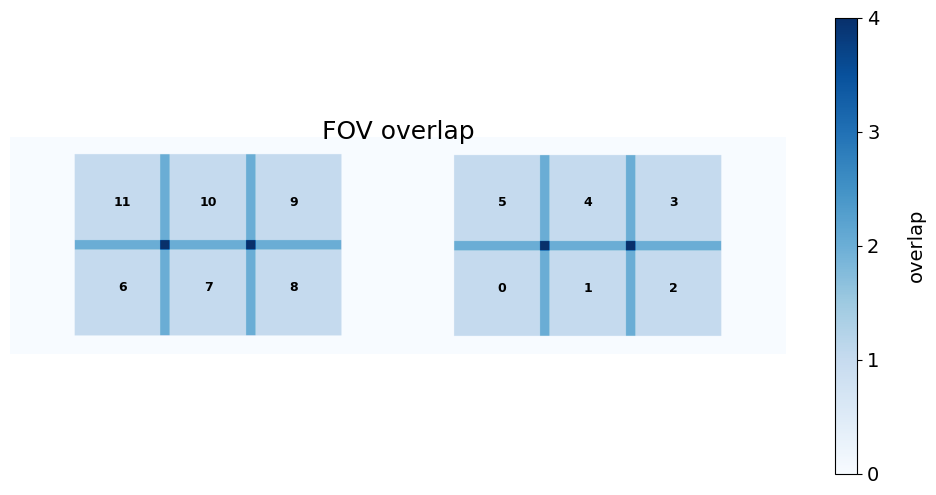

In [24]:
rep = 0
hpi = 5

coordinates = pd.read_csv(f"data/coordinates.csv").query("rep==@rep & hpi==@hpi & round==0")

RES = 1_000_000
x0 = coordinates["x_min"].min()
y0 = coordinates["y_min"].min()

coordinates["x_min_px"] = (coordinates["x_min"] - x0) * RES
coordinates["x_max_px"] = (coordinates["x_max"] - x0) * RES
coordinates["y_min_px"] = (coordinates["y_min"] - y0) * RES
coordinates["y_max_px"] = (coordinates["y_max"] - y0) * RES

x_pad = int((coordinates["x_max_px"].max() - coordinates["x_min_px"].min()) * 0.1)
y_pad = int((coordinates["y_max_px"].max() - coordinates["y_min_px"].min()) * 0.1)

width = int(coordinates["x_max_px"].max() - coordinates["x_min_px"].min()) + 2 * x_pad
height = int(coordinates["y_max_px"].max() - coordinates["y_min_px"].min()) + 2 * y_pad

canvas = np.zeros((height, width), dtype=int)

for _, row in coordinates.iterrows():
    x_min_px = int(row["x_min_px"]) + x_pad
    x_max_px = int(row["x_max_px"]) + x_pad
    y_min_px = int(row["y_min_px"]) + y_pad
    y_max_px = int(row["y_max_px"]) + y_pad
    canvas[y_min_px:y_max_px, x_min_px:x_max_px] += 1

fig, ax = plt.subplots(figsize=(10, 6))
extent = [
    x0 - x_pad / RES,
    x0 + (width - x_pad) / RES,
    y0 - y_pad / RES,
    y0 + (height - y_pad) / RES
]

im = ax.imshow(canvas, cmap='Blues', origin='lower', extent=extent)

for _, row in coordinates.iterrows():
    x_center = (row["x_min"] + row["x_max"]) / 2
    y_center = (row["y_min"] + row["y_max"]) / 2
    ax.text(x_center, y_center, f'{int(row["fov"])}',
            color='black', fontsize=9, ha='center', va='center', weight='bold')


cbar = fig.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label('overlap', fontsize=14)  
cbar.ax.tick_params(labelsize=14)
cbar.ax.yaxis.set_label_position('right')
cbar.ax.yaxis.labelpad = 20
cbar.locator = MaxNLocator(integer=True)
cbar.update_ticks()
ax.set_title("FOV overlap", fontsize=18, y=0.95)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_aspect('equal')
ax.set_axis_off()
plt.grid(False)
plt.tight_layout()
# plt.axes()
plt.show()

## Crop to common ROI

In [32]:
coords_common = (
    coords
    .groupby(["rep","hpi","fov"], as_index=False)
    .agg(
        x_min         = ("x_min", "max"),
        y_min         = ("y_min", "max"),
        x_max         = ("x_max", "min"),
        y_max         = ("y_max", "min"),
        pixel_size_h  = ("pixel_size_h", "first"),
        pixel_size_v  = ("pixel_size_v", "first"),
    )
)
coords_common.to_csv("data/coords_common.csv", index=False)
coords_common

,rep,hpi,fov,x_min,y_min,x_max,y_max,pixel_size_h,pixel_size_v
0,0,0,0,0.016421,0.029479,0.016626,0.029687,1.029826e-07,1.029826e-07
1,0,0,1,0.016611,0.029479,0.016816,0.029687,1.029826e-07,1.029826e-07
2,0,0,2,0.016801,0.029479,0.017006,0.029687,1.029826e-07,1.029826e-07
3,0,0,3,0.016801,0.029669,0.017006,0.029877,1.029826e-07,1.029826e-07
4,0,0,4,0.016611,0.029669,0.016816,0.029877,1.029826e-07,1.029826e-07
...,...,...,...,...,...,...,...,...,...
454,4,8,5,0.058130,0.047627,0.058334,0.047838,1.031250e-07,1.031250e-07
455,4,8,6,0.057940,0.047627,0.058144,0.047838,1.031250e-07,1.031250e-07
456,4,8,7,0.057749,0.047627,0.057954,0.047838,1.031250e-07,1.031250e-07
457,4,8,8,0.057559,0.047627,0.057763,0.047838,1.031250e-07,1.031250e-07


## Calculate overlaps

In [33]:
overlaps = []
grouped = coords_common.groupby(["rep", "hpi"])

for (rep, hpi), df in grouped:
    fovs = df["fov"].unique()

    for fov1, fov2 in combinations(fovs, 2):
        r1 = df[df["fov"] == fov1].iloc[0]
        r2 = df[df["fov"] == fov2].iloc[0]

        x_min_ov = max(r1.x_min, r2.x_min)
        x_max_ov = min(r1.x_max, r2.x_max)
        y_min_ov = max(r1.y_min, r2.y_min)
        y_max_ov = min(r1.y_max, r2.y_max)

        width_ov = x_max_ov - x_min_ov
        height_ov = y_max_ov - y_min_ov

        if width_ov > 0 and height_ov > 0:
            overlaps.append({
                "rep": rep,
                "hpi": hpi,
                "fov1": fov1,
                "fov2": fov2,
                "x_min_ov": x_min_ov,
                "x_max_ov": x_max_ov,
                "y_min_ov": y_min_ov,
                "y_max_ov": y_max_ov,
                "width_ov": width_ov,
                "height_ov": height_ov,
                "pixel_size_h": np.mean(df["pixel_size_h"].values),
                "pixel_size_v": np.mean(df["pixel_size_v"].values)
            })

overlaps_df = pd.DataFrame(overlaps)
overlaps_df

,rep,hpi,fov1,fov2,x_min_ov,x_max_ov,y_min_ov,y_max_ov,width_ov,height_ov,pixel_size_h,pixel_size_v
0,0,0,0,1,0.016611,0.016626,0.029479,0.029687,0.000015,0.000208,1.029826e-07,1.029826e-07
1,0,0,0,4,0.016611,0.016626,0.029669,0.029687,0.000015,0.000018,1.029826e-07,1.029826e-07
2,0,0,0,5,0.016421,0.016626,0.029669,0.029687,0.000205,0.000018,1.029826e-07,1.029826e-07
3,0,0,1,2,0.016801,0.016816,0.029479,0.029687,0.000015,0.000208,1.029826e-07,1.029826e-07
4,0,0,1,3,0.016801,0.016816,0.029669,0.029687,0.000015,0.000018,1.029826e-07,1.029826e-07
...,...,...,...,...,...,...,...,...,...,...,...,...
749,4,8,4,6,0.058129,0.058144,0.047627,0.047648,0.000015,0.000021,1.031250e-07,1.031250e-07
750,4,8,5,6,0.058130,0.058144,0.047627,0.047838,0.000014,0.000211,1.031250e-07,1.031250e-07
751,4,8,6,7,0.057940,0.057954,0.047627,0.047838,0.000014,0.000211,1.031250e-07,1.031250e-07
752,4,8,7,8,0.057749,0.057763,0.047627,0.047838,0.000014,0.000211,1.031250e-07,1.031250e-07


## Calculate overlaps in pixel

In [34]:
ov_px = overlaps_df.set_index(["rep","hpi"])

ov_px = ov_px.join(
    coords_common
      .set_index(["rep","hpi","fov"])
      .add_suffix("_fov1"),
    on=["rep","hpi","fov1"]
)

ov_px = ov_px.join(
    coords_common
      .set_index(["rep","hpi","fov"])
      .add_suffix("_fov2"),
    on=["rep","hpi","fov2"]
)

ov_px = ov_px.reset_index()

ov_px = ov_px.assign(
    x_min_px_fov1 = ((ov_px.x_min_ov - ov_px.x_min_fov1) / ov_px.pixel_size_h_fov1).round().astype(int),
    x_max_px_fov1 = ((ov_px.x_max_ov - ov_px.x_min_fov1) / ov_px.pixel_size_h_fov1).round().astype(int),
    y_min_px_fov1 = ((ov_px.y_min_ov - ov_px.y_min_fov1) / ov_px.pixel_size_v_fov1).round().astype(int),
    y_max_px_fov1 = ((ov_px.y_max_ov - ov_px.y_min_fov1) / ov_px.pixel_size_v_fov1).round().astype(int),

    x_min_px_fov2 = ((ov_px.x_min_ov - ov_px.x_min_fov2) / ov_px.pixel_size_h_fov2).round().astype(int),
    x_max_px_fov2 = ((ov_px.x_max_ov - ov_px.x_min_fov2) / ov_px.pixel_size_h_fov2).round().astype(int),
    y_min_px_fov2 = ((ov_px.y_min_ov - ov_px.y_min_fov2) / ov_px.pixel_size_v_fov2).round().astype(int),
    y_max_px_fov2 = ((ov_px.y_max_ov - ov_px.y_min_fov2) / ov_px.pixel_size_v_fov2).round().astype(int),
)
ov_px.to_csv("data/overlap_coords.csv", index=False)
ov_px

,rep,hpi,fov1,fov2,x_min_ov,x_max_ov,y_min_ov,y_max_ov,width_ov,height_ov,...,pixel_size_h_fov2,pixel_size_v_fov2,x_min_px_fov1,x_max_px_fov1,y_min_px_fov1,y_max_px_fov1,x_min_px_fov2,x_max_px_fov2,y_min_px_fov2,y_max_px_fov2
0,0,0,0,1,0.016611,0.016626,0.029479,0.029687,0.000015,0.000208,...,1.029826e-07,1.029826e-07,1843,1991,1,2018,0,148,0,2017
1,0,0,0,4,0.016611,0.016626,0.029669,0.029687,0.000015,0.000018,...,1.029826e-07,1.029826e-07,1844,1991,1842,2018,0,147,0,176
2,0,0,0,5,0.016421,0.016626,0.029669,0.029687,0.000205,0.000018,...,1.029826e-07,1.029826e-07,0,1991,1842,2018,0,1991,0,176
3,0,0,1,2,0.016801,0.016816,0.029479,0.029687,0.000015,0.000208,...,1.029826e-07,1.029826e-07,1842,1991,0,2017,0,149,0,2017
4,0,0,1,3,0.016801,0.016816,0.029669,0.029687,0.000015,0.000018,...,1.029826e-07,1.029826e-07,1842,1991,1840,2017,0,149,0,177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749,4,8,4,6,0.058129,0.058144,0.047627,0.047648,0.000015,0.000021,...,1.031250e-07,1.031250e-07,0,141,1843,2048,1838,1979,0,205
750,4,8,5,6,0.058130,0.058144,0.047627,0.047838,0.000014,0.000211,...,1.031250e-07,1.031250e-07,0,136,0,2048,1843,1979,0,2048
751,4,8,6,7,0.057940,0.057954,0.047627,0.047838,0.000014,0.000211,...,1.031250e-07,1.031250e-07,0,136,0,2048,1844,1979,0,2048
752,4,8,7,8,0.057749,0.057763,0.047627,0.047838,0.000014,0.000211,...,1.031250e-07,1.031250e-07,0,136,0,2048,1843,1979,0,2048


## Register overlaps

In [ ]:
ov_coords = pd.read_csv("data/overlap_coords.csv")

for i, coord in ov_coords.iterrows():
    rep = int(coord.rep)
    hpi = int(coord.hpi)
    fov1 = int(coord.fov1)
    fov2 = int(coord.fov2)
    if rep==1 and hpi==1 and fov1==0:
        print("no img")
        continue

    prefix1 = f"pipeline_output/final_pipe/3nt/PR8/rep{rep}/{hpi}hpi/fov_{fov1}"
    prefix2 = f"pipeline_output/final_pipe/3nt/PR8/rep{rep}/{hpi}hpi/fov_{fov2}"

    ## load images
    primary1 = xr.open_dataset(f"{prefix1}_primary.nc").__xarray_dataarray_variable__
    primary2 = xr.open_dataset(f"{prefix2}_primary.nc").__xarray_dataarray_variable__

    y0_fov1 = coord.y_min_px_fov1
    x0_fov1 = coord.x_min_px_fov1
    y0_fov2 = coord.y_min_px_fov2
    x0_fov2 = coord.x_min_px_fov2
    dy = y0_fov1 - y0_fov2
    dx = x0_fov1 - x0_fov2
    translate2 = (0, dy, dx)

    ## Registration overlaps
    crop_img1 = primary1.isel(
        y=slice(int(round(coord.y_min_px_fov1)), int(round(coord.y_max_px_fov1))),
        x=slice(int(round(coord.x_min_px_fov1)), int(round(coord.x_max_px_fov1)))
    )
    crop_img2 = primary2.isel(
        y=slice(int(round(coord.y_min_px_fov2)), int(round(coord.y_max_px_fov2))),
        x=slice(int(round(coord.x_min_px_fov2)), int(round(coord.x_max_px_fov2)))
    )
    if crop_img1.shape[3] <= 1 or crop_img1.shape[4] <= 1 or crop_img2.shape[3] <= 1 or crop_img2.shape[4] <= 1:
        print(crop_img1.shape, crop_img2.shape)
        print("zero size img")
        continue
    
    max1 = ImageStack.from_numpy(crop_img1)
    max2= ImageStack.from_numpy(crop_img2)
    max1 = max1.reduce({Axes.CH, Axes.ROUND}, func="max").xarray.squeeze()
    max2 = max2.reduce({Axes.CH, Axes.ROUND}, func="max").xarray.squeeze()

    y_common, x_common = min(max1.shape[0], max2.shape[0]), min(max1.shape[1], max2.shape[1])
    crop_max1 = max1.isel(x=slice(0, x_common), y=slice(0, y_common))
    crop_max2 = max2.isel(x=slice(0, x_common), y=slice(0, y_common))

    stack_np = np.stack([crop_max1.values, crop_max2.values], axis=0)
    stack_np = stack_np[:, np.newaxis, np.newaxis, :, :]
    stack_both = ImageStack.from_numpy(stack_np)

    learn_translation = LearnTransform.Translation(reference_stack=stack_both.sel({Axes.ROUND: 0}), axes=Axes.ROUND, upsampling=1000)
    warp = ApplyTransform.Warp()
    transform_list = learn_translation.run(stack_both)
    registered_stack = warp.run(stack_both, transforms_list=transform_list)
    path_json = f"data/overlap_transforms/rep{rep}_{hpi}hpi_overlap{fov1}{fov2}_registration.json"
    transform_list.to_json(path_json)

    with open(path_json, "r", encoding="utf-8") as file_reg:
        dict_reg = json.load(file_reg)
    tx = dict_reg["transforms_list"][1][2][0][2]
    ty = dict_reg["transforms_list"][1][2][1][2]
    tx *= -1
    ty *= -1

    ##common overlap
    h, w = crop_max1.shape
    y0 = max(0, 0)         
    y1 = min(h, h)
    y0 = max(y0, ty)
    y1 = min(y1, h+ty)

    x0 = max(0, 0)
    x1 = min(w, w)
    x0 = max(x0, tx)
    x1 = min(x1, w+tx)

    reg1 = registered_stack.xarray.sel({Axes.ROUND: 0}).squeeze().values
    reg2 = registered_stack.xarray.sel({Axes.ROUND: 1}).squeeze().values
    reg1 = reg1.astype(float)
    reg2 = reg2.astype(float)

    common1 = reg1[int(y0):int(y1), int(x0):int(x1)]
    common2 = reg2[int(y0):int(y1), int(x0):int(x1)]

    g_y0 = coord.y_min_px_fov1 + y0
    g_x0 = coord.x_min_px_fov1 + x0
    g_y1 = coord.y_min_px_fov1 + y1
    g_x1 = coord.x_min_px_fov1 + x1

    ## save overlap coords
    df = pd.DataFrame({
        "rep": [rep],
        "hpi": [hpi],
        "fov1": [fov1],
        "fov2": [fov2],
        "x0": [g_x0],
        "x1": [g_x1],
        "y0": [g_y0],
        "y1": [g_y1]
    })
    df.to_csv(f"data/overlap_coords/rep{rep}_hpi{hpi}_overlap{fov1}{fov2}.csv", index=False)

## Filter spots

In [ ]:
spots = pd.read_csv("data/all_spots.csv", keep_default_na=False, low_memory=False).query("densed_region_filtered==False & iter==''") ## -> from complex_analysis.ipynb
ov_coords = pd.read_csv("data/overlap_coords.csv")
spots_overlaps_df = pd.DataFrame()
spots

,intensity,z,y,x,radius,spot_id,z_min,z_max,y_min,y_max,...,cell,boundary_dist,border_cell,densed_region,densed_region_filtered,rep,hpi,fov,complex_size,iter
0,0.3612602,0.0,1217,1157,4.0,0,0.0,1.0,1214.0,1221.0,...,51,10.630146,False,False,False,0,0,1,2,
1,0.0012050039,0.0,1078,482,3.0,1,0.0,1.0,1076.0,1081.0,...,43,29.068884,False,False,False,0,0,1,1,
2,0.005784019,0.0,1201,1089,4.0,2,0.0,1.0,1198.0,1205.0,...,51,31.827661,False,False,False,0,0,1,1,
3,0.0074710245,0.0,678,868,3.0,3,0.0,1.0,676.0,681.0,...,24,67.201190,False,False,False,0,0,1,1,
4,0.0062660207,0.0,132,918,4.0,4,0.0,1.0,129.0,136.0,...,5,61.000000,True,False,False,0,0,1,1,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3484185,0.13602015,0.0,92,1349,4.0,21520,0.0,1.0,89.0,96.0,...,0,14.317821,True,False,False,4,8,7,1,
3484186,0.010075567,0.0,552,1119,2.0,21521,0.0,1.0,551.0,554.0,...,0,24.698178,True,False,False,4,8,7,1,
3484187,0.0,0.0,799,1172,2.0,21522,0.0,1.0,798.0,801.0,...,0,29.529646,True,False,False,4,8,7,1,
3484188,0.032745592,0.0,287,16,5.0,21525,0.0,1.0,283.0,292.0,...,0,172.000000,True,True,False,4,8,7,3,


In [16]:
for i, coord in ov_coords.iterrows():
    rep = int(coord.rep)
    hpi = int(coord.hpi)
    fov1 = int(coord.fov1)
    fov2 = int(coord.fov2)
    path = f"data/overlap_coords/rep{rep}_hpi{hpi}_overlap{fov1}{fov2}.csv"
    path_json = f"data/overlap_transforms/rep{rep}_{hpi}hpi_overlap{fov1}{fov2}_registration.json"

    if os.path.exists(path):
        spots1 = spots.query("rep==@rep & hpi==@hpi & fov==@fov1 & x>=@coord.x_min_px_fov1 & x<=@coord.x_max_px_fov1 & y>=@coord.y_min_px_fov1 & y<=@coord.y_max_px_fov1").copy()
        spots2 = spots.query("rep==@rep & hpi==@hpi & fov==@fov2 & x>=@coord.x_min_px_fov2 & x<=@coord.x_max_px_fov2 & y>=@coord.y_min_px_fov2 & y<=@coord.y_max_px_fov2").copy()
        spots1["z"] = 0
        spots2["z"] = 0
        spot_coords = pd.read_csv(path).iloc[0]
        y0_fov1 = coord.y_min_px_fov1
        x0_fov1 = coord.x_min_px_fov1
        y0_fov2 = coord.y_min_px_fov2
        x0_fov2 = coord.x_min_px_fov2
        dy = y0_fov1 - y0_fov2
        dx = x0_fov1 - x0_fov2
        
        with open(path_json, "r", encoding="utf-8") as file_reg:
            dict_reg = json.load(file_reg)
        tx = dict_reg["transforms_list"][1][2][0][2]
        ty = dict_reg["transforms_list"][1][2][1][2]
        tx *= -1
        ty *= -1
        
        g_x0 = spot_coords.x0
        g_x1 = spot_coords.x1
        g_y0 = spot_coords.y0
        g_y1 = spot_coords.y1

        spots1_ov = spots1.query("x>=@g_x0 & x<=@g_x1 & y>=@g_y0 & y<=@g_y1").copy()
        spots2_ov = spots2.copy()
        spots2_ov["x"] = spots2_ov["x"] + (dx + tx)
        spots2_ov["y"] = spots2_ov["y"] + (dy + ty)
        spots2_ov = spots2_ov.query("x>=@g_x0 & x<=@g_x1 & y>=@g_y0 & y<=@g_y1")

        spots_ov = pd.concat([spots1_ov, spots2_ov])
        spots_ov["overlap"] = f"{fov1}/{fov2}"
        spots_overlaps_df = pd.concat([spots_overlaps_df, spots_ov])


spots_overlaps_df["iter"] = ""
spots_overlaps_df.to_csv("data/overlap_spots_sbd.csv", index=False)

## Match spots

In [17]:
from functions import match_spots

In [18]:
spots_overlaps = pd.read_csv("data/overlap_spots_sbd.csv", keep_default_na=False, low_memory=False)
spots_overlaps.columns
spots_overlaps

,intensity,z,y,x,radius,spot_id,z_min,z_max,y_min,y_max,...,boundary_dist,border_cell,densed_region,densed_region_filtered,rep,hpi,fov,complex_size,iter,overlap
0,0.009227,0,470.000,1883.000,4.0,69,0.0,1.0,467.0,474.0,...,40.311289,True,False,False,0,0,0,1,,0/1
1,0.004935,0,153.000,1889.000,4.0,88,0.0,1.0,150.0,157.0,...,26.019224,False,False,False,0,0,0,1,,0/1
2,0.004935,0,222.000,1952.000,4.0,200,0.0,1.0,219.0,226.0,...,33.241540,True,False,False,0,0,0,1,,0/1
3,0.002520,0,71.000,1857.000,5.0,227,0.0,1.0,67.0,76.0,...,13.000000,False,False,False,0,0,0,1,,0/1
4,0.005471,0,321.000,1931.000,3.0,284,0.0,1.0,319.0,324.0,...,12.369317,True,False,False,0,0,0,1,,0/1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269708,0.000000,0,142.235,88.315,2.0,25276,0.0,1.0,150.0,153.0,...,260.345924,True,False,False,4,8,9,1,,8/9
269709,0.134422,0,1721.235,12.315,2.0,25314,0.0,1.0,1729.0,1732.0,...,99.624294,True,False,False,4,8,9,1,,8/9
269710,0.005739,0,887.235,44.315,2.0,25350,0.0,1.0,895.0,898.0,...,63.007936,True,False,False,4,8,9,1,,8/9
269711,0.000000,0,1179.235,42.315,2.0,25387,0.0,1.0,1187.0,1190.0,...,113.534136,True,False,False,4,8,9,1,,8/9


In [19]:
overlap_matches = []
for rep in range(total_reps):
    for hpi in range(total_hpis):
        spots_hpi = spots_overlaps.query("rep==@rep & hpi==@hpi").copy()

        for overlap in spots_hpi["overlap"].unique():
            spots_ov = spots_hpi.query("overlap==@overlap").copy()
            fov1, fov2 = int(overlap.split("/")[0]), int(overlap.split("/")[1])

            if len(spots_ov) == 0:
                print("no spots", rep, hpi, overlap)
                continue
            
            if len(spots_ov.query("fov==@fov1")) == 0 or len(spots_ov.query("fov==@fov2")) == 0:
                if spots_ov["fov"].unique()[0] == fov1:
                    for i, row in spots_ov.iterrows():
                        overlap_matches.append({
                            "rep": rep,
                            "hpi": hpi,
                            "overlap": overlap,
                            "fov1": fov1,
                            "x_fov1": row["x"],
                            "y_fov1": row["y"],
                            "target_fov1": row["target"],
                            "iter_fov1": row["iter"],
                            "fov2": fov2,
                            "x_fov2": -1,
                            "y_fov2": -1,
                            "target_fov2": "None",
                            "iter_fov2": "None",
                            "match": False
                        })
                    
                    # print(spots_ov[["fov", "overlap"]])
                    # print(fov1)
                    # print(pd.DataFrame(overlap_matches))
                    # print("__________________")
                    continue
                    

                elif spots_ov["fov"].unique()[0] == fov2:
                    for i, row in spots_ov.iterrows():
                        overlap_matches.append({
                            "rep": rep,
                            "hpi": hpi,
                            "overlap": overlap,
                            "fov1": fov1,
                            "x_fov1": -1,
                            "y_fov1": -1,
                            "target_fov1": "None",
                            "iter_fov1": "None",
                            "fov2": fov2,
                            "x_fov2": row["x"],
                            "y_fov2": row["y"],
                            "target_fov2": row["target"],
                            "iter_fov2": row["iter"],
                            "match": False
                        })
                        
                    # print(spots_ov[["fov", "overlap"]])
                    # print(fov2)
                    # print(pd.DataFrame(overlap_matches))
                    # print("__________________")
                    continue



            spots1 = spots_ov.query("fov==@fov1").reset_index(drop=True)
            spots2 = spots_ov.query("fov==@fov2").reset_index(drop=True)

            fov1_coords = list(zip(spots1.x, spots1.y))
            fov2_coords = list(zip(spots2.x, spots2.y))

            matches = match_spots(fov1_coords, fov2_coords, 5)

            for match in matches:
                fov1_idx, fov2_idx = match
                fov1_x, fov1_y = fov1_coords[fov1_idx]
                fov2_x, fov2_y = fov2_coords[fov2_idx]

                overlap_matches.append({
                    "rep": rep,
                    "hpi": hpi,
                    "overlap": overlap,
                    "fov1": fov1,
                    "x_fov1": fov1_x,
                    "y_fov1": fov1_y,
                    "target_fov1": spots1.iloc[fov1_idx]["target"],
                    "iter_fov1": spots1.iloc[fov1_idx]["iter"],
                    "fov2": fov2,
                    "x_fov2": fov2_x,
                    "y_fov2": fov2_y,
                    "target_fov2": spots2.iloc[fov2_idx]["target"],
                    "iter_fov2": spots2.iloc[fov2_idx]["iter"],
                    "match": True
                })
            
            matched_fov1 = {match[0] for match in matches}
            matched_fov2 = {match[1] for match in matches}

            for idx, spot in spots1.iterrows():
                if idx not in matched_fov1:
                    overlap_matches.append({
                        "rep": rep,
                        "hpi": hpi,
                        "overlap": overlap,
                        "fov1": fov1,
                        "x_fov1": spot["x"],
                        "y_fov1": spot["y"],
                        "target_fov1": spot["target"],
                        "iter_fov1": spot["iter"],
                        "fov2": fov2,
                        "x_fov2": -1,
                        "y_fov2": -1,
                        "target_fov2": "None",
                        "iter_fov2": "None",
                        "match": False
                    })


            for idx, spot in spots2.iterrows():
                if idx not in matched_fov2:
                    overlap_matches.append({
                        "rep": rep,
                        "hpi": hpi,
                        "overlap": overlap,
                        "fov1": fov1,
                        "x_fov1": -1,
                        "y_fov1": -1,
                        "target_fov1": "None",
                        "iter_fov1": "None",
                        "fov2": fov2,
                        "x_fov2": spot["x"],
                        "y_fov2": spot["y"],
                        "target_fov2": spot["target"],
                        "iter_fov2": spot["iter"],
                        "match": False
                    })

overlap_matches_df = pd.DataFrame(overlap_matches)
overlap_matches_df[['iter_fov1', 'iter_fov2']] = overlap_matches_df[['iter_fov1', 'iter_fov2']].replace('', np.nan).fillna('SBD')
for col in ['iter_fov1','iter_fov2']:
    overlap_matches_df.loc[overlap_matches_df[col].isin(['0.0', '1.0', '2.0']), col] = 'PBD'
overlap_matches_df = overlap_matches_df.rename(columns={"iter_fov1": "method_fov1", "iter_fov2": "method_fov2"})
overlap_matches_df.to_csv("data/overlap_matches_sbd.csv", index=False)
overlap_matches_df

,rep,hpi,overlap,fov1,x_fov1,y_fov1,target_fov1,method_fov1,fov2,x_fov2,y_fov2,target_fov2,method_fov2,match
0,0,0,0/1,0,1883.0,470.0,NA,SBD,1,1882.308,469.804,NA,SBD,True
1,0,0,0/1,0,1952.0,222.0,M,SBD,1,1949.308,223.804,M,SBD,True
2,0,0,0/1,0,1857.0,71.0,NA,SBD,1,1853.308,71.804,missing,SBD,True
3,0,0,0/1,0,1931.0,321.0,NA,SBD,1,1930.308,321.804,NA,SBD,True
4,0,0,0/1,0,1904.0,1489.0,missing,SBD,1,1903.308,1487.804,missing,SBD,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223407,4,8,8/9,8,-1.0,-1.0,None,None,9,25.315,34.235,NS,SBD,False
223408,4,8,8/9,8,-1.0,-1.0,None,None,9,88.315,142.235,missing,SBD,False
223409,4,8,8/9,8,-1.0,-1.0,None,None,9,12.315,1721.235,missing,SBD,False
223410,4,8,8/9,8,-1.0,-1.0,None,None,9,44.315,887.235,missing,SBD,False


## Barcode distance

In [1]:
from functions import get_bases_from_segments, get_distance_from_bases_overlap

In [6]:
overlap_matches_df = pd.read_csv("data/overlap_matches_sbd.csv", keep_default_na=False)
overlap_matches_df

,rep,hpi,overlap,fov1,x_fov1,y_fov1,target_fov1,method_fov1,fov2,x_fov2,y_fov2,target_fov2,method_fov2,match
0,0,0,0/1,0,1883.0,470.0,NA,SBD,1,1882.308,469.804,NA,SBD,True
1,0,0,0/1,0,1952.0,222.0,M,SBD,1,1949.308,223.804,M,SBD,True
2,0,0,0/1,0,1857.0,71.0,NA,SBD,1,1853.308,71.804,missing,SBD,True
3,0,0,0/1,0,1931.0,321.0,NA,SBD,1,1930.308,321.804,NA,SBD,True
4,0,0,0/1,0,1904.0,1489.0,missing,SBD,1,1903.308,1487.804,missing,SBD,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223407,4,8,8/9,8,-1.0,-1.0,None,None,9,25.315,34.235,NS,SBD,False
223408,4,8,8/9,8,-1.0,-1.0,None,None,9,88.315,142.235,missing,SBD,False
223409,4,8,8/9,8,-1.0,-1.0,None,None,9,12.315,1721.235,missing,SBD,False
223410,4,8,8/9,8,-1.0,-1.0,None,None,9,44.315,887.235,missing,SBD,False


In [7]:
overlap_matches_df["bases_fov1"] = [get_bases_from_segments(segment) for segment in overlap_matches_df["target_fov1"]]
overlap_matches_df["bases_fov2"] = [get_bases_from_segments(segment) for segment in overlap_matches_df["target_fov2"]]
overlap_matches_df[["bases_fov1", "bases_fov2"]] = overlap_matches_df[["bases_fov1", "bases_fov2"]].fillna("None")
overlap_matches_df["barcode_distance"] = [get_distance_from_bases_overlap(overlap_matches_df.iloc[i]["bases_fov1"], overlap_matches_df.iloc[i]["bases_fov2"]) for i in range(len(overlap_matches_df))]
overlap_matches_df.to_csv("data/overlap_matches_with_distances_sbd.csv", index=False)
overlap_matches_df

,rep,hpi,overlap,fov1,x_fov1,y_fov1,target_fov1,method_fov1,fov2,x_fov2,y_fov2,target_fov2,method_fov2,match,bases_fov1,bases_fov2,barcode_distance
0,0,0,0/1,0,1883.0,470.0,NA,SBD,1,1882.308,469.804,NA,SBD,True,"T,T,C","T,T,C",0
1,0,0,0/1,0,1952.0,222.0,M,SBD,1,1949.308,223.804,M,SBD,True,"T,G,A","T,G,A",0
2,0,0,0/1,0,1857.0,71.0,NA,SBD,1,1853.308,71.804,missing,SBD,True,"T,T,C",invalid,invalid/valid
3,0,0,0/1,0,1931.0,321.0,NA,SBD,1,1930.308,321.804,NA,SBD,True,"T,T,C","T,T,C",0
4,0,0,0/1,0,1904.0,1489.0,missing,SBD,1,1903.308,1487.804,missing,SBD,True,invalid,invalid,both invalid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223407,4,8,8/9,8,-1.0,-1.0,None,None,9,25.315,34.235,NS,SBD,False,None,"T,G,T",None/valid
223408,4,8,8/9,8,-1.0,-1.0,None,None,9,88.315,142.235,missing,SBD,False,None,invalid,None/invalid
223409,4,8,8/9,8,-1.0,-1.0,None,None,9,12.315,1721.235,missing,SBD,False,None,invalid,None/invalid
223410,4,8,8/9,8,-1.0,-1.0,None,None,9,44.315,887.235,missing,SBD,False,None,invalid,None/invalid


## Plots

In [24]:
method = "SBD"
overlap_matches = overlap_matches_df[(overlap_matches_df["barcode_distance"] != "None/valid") & (overlap_matches_df["barcode_distance"] != "None/invalid")]
overlap_matches

,rep,hpi,overlap,fov1,x_fov1,y_fov1,target_fov1,method_fov1,fov2,x_fov2,y_fov2,target_fov2,method_fov2,match,bases_fov1,bases_fov2,barcode_distance
0,0,0,0/1,0,1883.0,470.0,NA,SBD,1,1882.308,469.804,NA,SBD,True,"T,T,C","T,T,C",0
1,0,0,0/1,0,1952.0,222.0,M,SBD,1,1949.308,223.804,M,SBD,True,"T,G,A","T,G,A",0
2,0,0,0/1,0,1857.0,71.0,NA,SBD,1,1853.308,71.804,missing,SBD,True,"T,T,C",invalid,invalid/valid
3,0,0,0/1,0,1931.0,321.0,NA,SBD,1,1930.308,321.804,NA,SBD,True,"T,T,C","T,T,C",0
4,0,0,0/1,0,1904.0,1489.0,missing,SBD,1,1903.308,1487.804,missing,SBD,True,invalid,invalid,both invalid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223084,4,8,8/9,8,121.0,1202.0,NS(invalid),SBD,9,120.315,1203.235,NA,SBD,True,invalid,"T,T,C",invalid/valid
223085,4,8,8/9,8,64.0,1223.0,missing,SBD,9,63.315,1224.235,"PB2,PA(invalid)",SBD,True,invalid,invalid,both invalid
223086,4,8,8/9,8,13.0,1733.0,missing,SBD,9,12.315,1730.235,missing,SBD,True,invalid,invalid,both invalid
223087,4,8,8/9,8,106.0,1283.0,M(invalid),SBD,9,104.315,1283.235,missing,SBD,True,invalid,invalid,both invalid


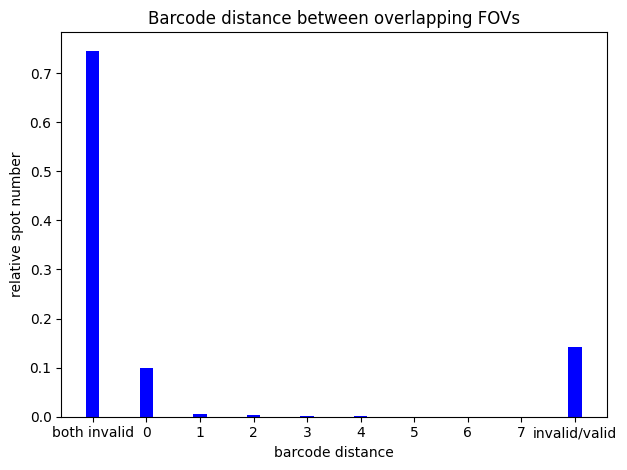

In [ ]:
y_values_all = []
x_values_all = []
for x_val in overlap_matches.barcode_distance:
    if str(x_val) not in x_values_all:
        x_values_all.append(str(x_val))
sortierreihenfolge = ["both invalid", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "None", "invalid/valid", "None/valid"]
x_values_all = sorted(
    x_values_all, 
    key=lambda x: sortierreihenfolge.index(x) if x in sortierreihenfolge else len(sortierreihenfolge) + ord(x[0])
)

for x_val in x_values_all:
    y_values_all.append(len(overlap_matches[overlap_matches["barcode_distance"].astype(str) == x_val]))
y_values_rel = [y_values_all[i]/sum(y_values_all) for i in range(len(y_values_all))]

bar_width = 0.25
fig, ax = plt.subplots()
ax.bar(x_values_all, y_values_rel, bar_width, color="blue")
ax.set_xlabel("barcode distance")
ax.set_ylabel("relative spot number")
ax.set_title("Barcode distance between overlapping FOVs")
ax.set_xticks(x_values_all)
ax.set_xticklabels(x_values_all)
#plt.savefig("pipeline_evaluation_results/overlap_barcode_distance_sbd.png")
plt.tight_layout()
plt.show()